In [1]:
#!/usr/bin/env python3
#title           :mcdwt_evaluate.py
#description     :script for evaluation of mcdwt algorythm from repository: https://github.com/Sistemas-Multimedia/MCDWT
#author          :Nabel Hernandez Margin,
#                 Ángeles Garcia de las Heras,
#                 Manuel Gonzalez Rodriguez,
#                 Jose Carlos Fuentes Angulo,
#                 Viktor Sobolyev
#date            :06022020
#version         :0.3
#notes           :Script intended to be used on a linux machine. Not compatible with any Windows OS
#python_version  :3.5.1
#==============================================================================
import shutil
import wget
import sys
import getopt
import os
from subprocess import Popen, PIPE, check_output
import numpy as np
import cv2

MIDRISE = 'midrise'
MIDTHREAD = 'midthread'
DEADZONE = 'deadzone'
QUANTIZIERS = [MIDRISE, MIDTHREAD, DEADZONE]
HH = 'HH'
HL = 'HL'
LH = 'LH'
LL = 'LL'
SUBBANDS = [HH, HL, LH, LL]
N_ITERATIONS = 0
VIDEOFILE_NAME = 'test_video'
VIDEOFILE_URL = ''
DEFAULT_DIR = '/tmp/mcdwt/'
TMP_DIR = ''
LOOP_STEP = 1
POWER_OF_TWO = True
DEBUG = False #__debug__

def my_print(msg):
   if DEBUG:
      print(msg)

def do_cleanup(tmp_dir):
   '''
   Clean working directory
   Parameters
   ----------
   tmp_dir - string dir location

   Returns
   -------
   none
   '''
   my_print('Limpiando directorio de trabajo: %s' % tmp_dir)
   if (os.path.exists(tmp_dir)):
      try:
         shutil.rmtree(tmp_dir)
      except:
         print('Error while deleting directory')
   os.makedirs(tmp_dir, exist_ok=True)


def download_file_to_folder(videofile_url, videofile_name):
   '''
   Download video to location and assign name to videofile
   Parameters
   ----------
   videofile_url - video url
   videofile_name - location and filename for the video

   Returns
   -------

   '''
   my_print('Descargando archivo: \'%s\' a \'%s\'' % (videofile_url, videofile_name))
   res = wget.download(videofile_url, out=videofile_name)
   my_print('\n')
   return res


def extract_frames(tmp_dir, gop, videofile):
   '''
   Extract frames using ffmpeg and rename generated images from 001..999 to 000..999
   Files will be placed in directory TMP_DIR/GOP
   Parameters
   ----------
   TMP_DIR - DIRECTORY FOR THE IMAGES
   GOP - GROUP OF IMAGES

   Returns
   -------
   base directory with original images
   '''
   my_print('Extrayendo %s imagenes a %s' % (str(gop), tmp_dir))
   # ffmpeg -hide_banner -loglevel info -i $file -vframes 9 $folder%03d.png &
   base_dir = tmp_dir + str(gop) + os.sep
   pattern_dir = base_dir + 'original' + os.sep
   os.makedirs(pattern_dir, exist_ok=True)
   pattern = pattern_dir + '%3d.png'
   args = ['ffmpeg', '-hide_banner', '-loglevel', 'info', '-i', videofile, '-vframes', str(gop), pattern]
   execute_command(args)

   # fix frame numbering
   for i in range(1, gop):
      from_file = pattern_dir + str(i).zfill(3) + '.png'
      to_file = pattern_dir + str(i - 1).zfill(3) + '.png'
      shutil.copy(from_file, to_file)

   # remove last file
   rmfile = pattern_dir + str(gop).zfill(3) + '.png'
   os.remove(rmfile)

   # copy originals to res directory where algorythm will be applied
   res_dir = base_dir + 'res' + os.sep
   shutil.copytree(pattern_dir, res_dir)
   return base_dir


def execute_mdwt(image_directory, gop, inverse=False):
   '''
   calls mcdwt algorythm
   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)

   Returns
   -------
   POPEN object
   '''
   my_print('Ejecutando MDWT.py para %s imagenes inverse: %s' %(str(gop), str(inverse)))
   # MDWT.py -N $num_imgs -p /tmp/
   args = ['python3', '-O', 'MDWT.py', '-N', str(gop), '-p', image_directory]
   if inverse == True: args.append('-b')
   return execute_command(args)


def execute_mcdwt(image_directory, gop, n_iteration, predictor=1, inverse=False):
   '''

   Parameters
   ----------
   image_directory - location of the images to process
   gop - group of pictures (number of images to process)
   n_iteration - number of iterations
   predictor - predictor value

   Returns
   -------
   POPEN object
   '''
   my_print('Ejecutando MCDWT.py para imagenes %s, predictor %s, iteraciones %s inverse: %s' %(str(gop), str(predictor),
                                                                                            str(n_iteration), str(inverse)))
   # !python3 -O MCDWT.py -N $num_imgs -P $predictor -p /tmp/ -T $iterations
   args = ['python3', '-O', 'MCDWT.py', '-N', str(gop - 1), '-P', str(predictor), '-p', image_directory, '-T',
           str(n_iteration)]
   if inverse == True: args.append('-b')
   return execute_command(args)


def execute_command(args, cmd=None, shell=False):
   '''
   executes command in shell
   Parameters
   ----------
   args - command and arguments
   cmd - required for rm command
   shell - popen shell parameter

   Returns
   -------

   '''
   if cmd is None:
      p = Popen(args, stdin=PIPE, stdout=PIPE, stderr=PIPE, shell=shell)
   else:
      p = Popen("%s %s" % (cmd, args), shell=True, stdin=PIPE, stdout=PIPE, stderr=PIPE)
   p.wait()
   return p


def get_pathsize(path, suffix="B"):
   '''
   return dir/file size
   Parameters
   ----------
   path - file or folder path
   suffix - result size suffix ['B','MB','KB','GB','TB']

   Returns
   -------

   '''
   res = int(check_output(['du', '-sb', path]).split()[0].decode('utf-8'))
   my_print('sizeof: %s: %s' % (path, str(res)))
   return get_size_format(res, suffix=suffix)


def get_size_format(b, suffix="B"):
   '''
   Transform value in bytes (integer) into KB,MB,GB,TB
   Parameters
   ----------
   b - integer value in bytes
   suffix - KB,MB,GB,TB

   Returns
   -------
   integer value in B,KB,MB,GB,TB
   '''
   if isinstance(b, int):
      if suffix == "B":
         pass
      elif suffix == "KB":
         b = int(b / 1024)
      elif suffix == "MB":
         b = int(b / 1024 ** 2)
      elif suffix == "GB":
         b = int(b / 1024 ** 3)
      elif suffix == "TB":
         b = int(b / 1024 ** 4)
      else:
         print('WRONG FORMAT: \'>%s<\', RETURNING KB' % suffix)
   else:
      raise ValueError("var: %s of type: \'%s\' is not an int" % (str(b), type(b)))
   return b



def prepare_current_iteration_directory(tmp_dir, curr_gop, gop):
   '''
   Copy all the images to the directory for the current iteration and remove
   pictures that won't be processed for the current gop number
   Parameters
   ----------
   tmp_dir - working directory
   curr_gop - current gop number
   gop - total gop number

   Returns
   -------
   destination directory (string)
   '''
   srt_dir = tmp_dir + str(gop) + os.sep
   dst_dir = tmp_dir + str(curr_gop) + os.sep
   my_print('Copiando %s imagenes al directorio: %s' %(str(curr_gop), dst_dir))
   #os.makedirs(tmp_dir, exist_ok=True)
   shutil.copytree(srt_dir, dst_dir)
   #remove extra images
   for i in range(curr_gop, gop):
      rm_file_original = dst_dir + 'original' + os.sep + str(i).zfill(3) + '.png'
      rm_file_res = dst_dir + 'res' + os.sep + str(i).zfill(3) + '.png'
      os.remove(rm_file_original)
      os.remove(rm_file_res)
   return dst_dir


def quantize_image_function(input_path, output_path, q_step, quantize_algorithm):
   # Read image
   image = cv2.imread(input_path, -1)
   # Transformation needed because Vicente said in forum
   tmp = image.astype(np.float32)
   tmp -= 32768

   if quantize_algorithm == MIDRISE:
      image = np.floor(tmp / q_step).astype(np.int16) * q_step + (q_step / 2)
   elif quantize_algorithm == MIDTHREAD:
      image = np.round(tmp / q_step).astype(np.int16) * q_step
   elif quantize_algorithm == DEADZONE:
      image = (tmp / q_step).astype(np.int16) * q_step
   else:
      image = (tmp / q_step).astype(np.int16) * q_step  # Vicente's quantizer.py algorithm ///-> deadzone

   # Transformation needed because Vicente said in forum
   tmp = image.astype(np.float32)
   tmp += 32768
   image = tmp.astype(np.uint16)

   # Write image quantizied
   cv2.imwrite(output_path, image)

def mse(path_A, path_B):
   '''
   mean( (A-B)**2 )
   Parameters
   ----------
   path_A - A image path
   path_B - B image path

   Returns
   -------
   mse value
   '''
   # the 'Mean Squared Error' between the two images is the
   # sum of the squared difference between the two images;
   # NOTE: the two images must have the same dimension

   A = cv2.imread(path_A, -1)
   B = cv2.imread(path_B, -1)
   err = np.sum((A - B) ** 2)
   err /= float(A.shape[0] * A.shape[1])

   return err

def func_qstep(qstep):
   if POWER_OF_TWO == True:
      qstep = int(pow(2, qstep))
   return qstep

def quantisize_images(tmp_dir, videofile_url, n_iterations, allsubbands=True, predictor=2, suffix='B', q_step=None, min_qstep=1, max_qstep=6, loopstep=None, powered_iterations=None, normalize=False):
   '''
   Runs quantization test for 3 defined algorithms (deadzone, midthread, midrise)
   Parameters
   ----------
   tmp_dir (str): directory for the algorythm to download video, extract images and subbands
   videofile_url (str): url of the videofile to extract images from
   n_iterations (int): value of the iterations for mcdwt algorythm
   predictor (int): value of the predictor for mcdwt algorythm
   suffix (str): suffix for the size of images, possible values: B, KB, MB, GB, TB
   q_step (int): start qstep iterations with value 1 and end with value q_step
   min_qstep (int): start qstep iterations with value
   max_qstep (int): end qstep iterations with value
   loopstep (int): value of qstep loop increment, default 1 (1,2,3,4,5...)
   powered_iterations (boolean) : if set to true, iterations of qstep for the quantisizer will be assigned a value of, qstep = 2^iteration_value
   normalize (boolean): normalizes images after finishing algorythm execution

   Returns
   -------
   json
   example to extract data from resulting json mse_value:
   def separate_msevalues_results(mse_values, mse_dz=[], mse_mr=[], mse_mt=[], size_dz=[], size_mr=[], size_mt=[]):
    # mse arrays
    # mse_dz = []#deadzone
    # mse_mr = []#midrise
    # mse_mt = []#midthread

    # x - q size values
    # size_dz = []
    # size_mr = []
    # size_mt = []
    for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
        mse_dz.append(np.mean(mse_values['deadzone'][str(func_qstep(i))]['mse']))
        size_dz.append(mse_values['deadzone'][str(func_qstep(i))]['size'])

        mse_mr.append(np.mean(mse_values['midrise'][str(func_qstep(i))]['mse']))
        size_mr.append(mse_values['midrise'][str(func_qstep(i))]['size'])

        mse_mt.append(np.mean(mse_values['midthread'][str(func_qstep(i))]['mse']))
        size_mt.append(mse_values['midthread'][str(func_qstep(i))]['size'])
   '''
   global DEFAULT_DIR
   global POWER_OF_TWO
   global LOOP_STEP
   if loopstep is not None: LOOP_STEP = loopstep
   if powered_iterations is not None: POWER_OF_TWO = powered_iterations
   if min_qstep > max_qstep: min_qstep= max_qstep
   if max_qstep < min_qstep: max_qstep = min_qstep
   if q_step is not None: min_qstep = max_qstep = q_step
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   if not tmp_dir.endswith(os.sep): tmp_dir += os.sep
   # execute mdwt and mcdwt
   original, compressed = compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=predictor, suffix=suffix)

   # prepare directories
   curr_dir = tmp_dir + str(pow(2, n_iterations)) + os.sep

   # get res directory path
   res_dir = curr_dir + 'res' + os.sep

   # read image names from res directory (compressed)
   img_arr = [name for name in os.listdir(res_dir) if (os.path.isfile(os.path.join(res_dir, name)) and name.endswith('.png'))]
   my_print('--------------------------------------------------------------------------------------------')
   my_print('cuantificando imagenes arrlength: %s' %(str(len(img_arr))))
   my_print('--------------------------------------------------------------------------------------------')
   # quantify images applying q_step 1..max_qstep
   for q_func in QUANTIZIERS:
      my_print('cuantificandor: %s ' % (q_func))
      for img_name in img_arr:
         src_image = res_dir + img_name
         #for qstep in range(min_qstep, max_qstep + 1):
         for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
            qstep = func_qstep(qstep)

            dst_dir = curr_dir + q_func + os.sep + str(qstep).zfill(2) + os.sep + 'res' + os.sep
            os.makedirs(dst_dir, exist_ok=True)
            dst_image = dst_dir + img_name
            quantize_image_function(src_image, dst_image, qstep, q_func)
   my_print('--------------------------------------------------------------------------------------------')
   my_print('descopmrimiendo imagenes cuantificadas')
   my_print('--------------------------------------------------------------------------------------------')
   mse_values = {}
   mse_values[DEADZONE] = {}
   mse_values[MIDTHREAD] = {}
   mse_values[MIDRISE] = {}
   for q_func in QUANTIZIERS:
      #for qstep in range(min_qstep, max_qstep + 1):
      for qstep in range(min_qstep, max_qstep + 1, LOOP_STEP):
         qstep = func_qstep(qstep)

         mse_values[q_func][str(qstep)] = {}
         if allsubbands == True:
            mse_values[q_func][str(qstep)]['mse'] = []
            mse_values[q_func][str(qstep)]['size'] = -1
         else:
            mse_values[q_func][str(qstep)] = {}
            for sb in SUBBANDS:
               mse_values[q_func][str(qstep)][sb] = {
                  'mse': [],
                  'size': []
               }


         my_print('cuantificandor: %s, qstep: %s ' % (q_func, qstep))
         q_dir = curr_dir + q_func + os.sep + str(qstep).zfill(2) + os.sep
         qres_dir = q_dir + 'res' + os.sep
         qdst_dir = q_dir + 'decompressed' + os.sep

         my_print('copiando imagenes antes de descomprimir: %s -> %s' %(qres_dir, qdst_dir))
         shutil.copytree(qres_dir, qdst_dir)

         my_print('--------------------------------------------------------------------------------------------')
         my_print('calculando peso del directorio de las subbandas para q_func: %s, qstep: %s' % (q_func, qstep))
         #qdst_dir
         if allsubbands == True:
            mse_values[q_func][str(qstep)]['size'] = get_pathsize(qdst_dir, suffix='B')
         else:
            img_arr = [name for name in os.listdir(qres_dir) if (os.path.isfile(os.path.join(qres_dir, name)) and name.endswith('.png'))]
            for img_name in img_arr:
               img_A = curr_dir + 'res' + os.sep + img_name
               img_B = qdst_dir + img_name
               mse_val = mse(img_A, img_B)
               size = get_pathsize(img_B)
               for sb in SUBBANDS:
                  if img_name.startswith(sb):
                     mse_values[q_func][str(qstep)][sb]['mse'].append(mse_val)
                     mse_values[q_func][str(qstep)][sb]['size'].append(size)

         #python3 -O MCDWT.py -P $predictor -p /tmp/ -b
         execute_mcdwt(qdst_dir, pow(2, n_iterations), n_iterations, predictor=predictor, inverse=True)
         #python3 -O MDWT.py -p /tmp/ -b
         execute_mdwt(qdst_dir, pow(2, n_iterations), inverse=True)
         my_print('eliminando subbandas (rm -rf ?????.png)')
         cmd = 'rm'
         args = '-rf %s?????.png' %qdst_dir
         execute_command(args, cmd=cmd, shell=True)
         my_print('--------------------------------------------------------------------------------------------')
         my_print('calculando mse para q_func: %s, qstep: %s' %(q_func, qstep))
         img_arr = [name for name in os.listdir(qdst_dir) if (os.path.isfile(os.path.join(qdst_dir, name)) and name.endswith('.png'))]
         my_print('directorio: %s' %qdst_dir)
         my_print(str(img_arr))

         if allsubbands == True:
            for img_name in img_arr:
               img_A = curr_dir + 'original' + os.sep + img_name
               img_B = qdst_dir + img_name
               mse_val = mse(img_A, img_B)
               mse_values[q_func][str(qstep)]['mse'].append(mse_val)

         if normalize == True:
            my_print('--------------------------------------------------------------------------------------------')
            my_print('normalizando imagenes cuantificadas')
            my_print('--------------------------------------------------------------------------------------------')
            img_arr = [name for name in os.listdir(qdst_dir) if (os.path.isfile(os.path.join(qdst_dir, name)) and len(name)<8)]
            for img in img_arr:
               img = qdst_dir + img
               args = ['convert', '-normalize', img, img]
               execute_command(args)

   return mse_values



def compress_mcdwt_once(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B'):
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   if (n_iterations == 0):
      raise Exception("El número de iteraciones no puede ser igual a 0")
   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   all_images_dir = extract_frames(tmp_dir, pow(2, n_iterations), videofile)

   curr_gop = pow(2, n_iterations)
   curr_dir = all_images_dir
   res_dir = curr_dir + 'res' + os.sep
   # execute MDWT algorythm
   execute_mdwt(res_dir, curr_gop)
   # execute MCDWT algorythm
   execute_mcdwt(res_dir, curr_gop, n_iterations, predictor)

   # remove original files from compressed directory
   rm_pattern = res_dir + '???.png'
   cmd = 'rm'
   args = '-rf %s' % rm_pattern
   execute_command(args, cmd=cmd, shell=True)

   # calculate size of directories
   my_print('Calculando tamaño de directorios')
   original_dir = curr_dir + 'original' + os.sep
   y = get_pathsize(original_dir, suffix=suffix)
   y1 = get_pathsize(res_dir, suffix=suffix)
   y_arr.append(y)
   y1_arr.append(y1)
   return y_arr, y1_arr

def compress_mcdwt_iterative(tmp_dir, videofile_url, n_iterations, predictor=1, suffix='B'):
   '''
   Main function, executes the process of running all the steps to compress images
   and calculate the size of them before and after compression
   Parameters
   ----------
   tmp_dir - working directory to extract images from the video and do processing
   videofile_url - url of the video
   n_iterations - number of iterations for mcdwt
   predictor - predictor value
   suffix - suffix for directory size (default=B,KB,MB,GB)

   Returns
   -------
   Two arrays: original_sizes, compressed sizes
   '''
   global DEFAULT_DIR
   if (tmp_dir == ''): tmp_dir = DEFAULT_DIR
   y_arr = []
   y1_arr = []

   if (n_iterations == 0):
      raise Exception("El número de iteraciones no puede ser igual a 0")
   # cleanup
   do_cleanup(tmp_dir)
   # download file
   videofile = tmp_dir + VIDEOFILE_NAME
   download_file_to_folder(videofile_url, videofile)

   # extract frames ONCE to folder
   all_images_dir = extract_frames(tmp_dir, pow(2, n_iterations), videofile)

   for curr_iteration in range(1, n_iterations + 1):
      curr_gop = pow(2, curr_iteration)
      #prepare directory
      if curr_gop != pow(2, n_iterations):
         curr_dir = prepare_current_iteration_directory(tmp_dir, curr_gop, pow(2, n_iterations))
      else:
         curr_dir = all_images_dir

      # execute MDWT algorythm
      res_dir = curr_dir + 'res' + os.sep
      execute_mdwt(res_dir, curr_gop)
      # execute MCDWT algorythm
      execute_mcdwt(res_dir, curr_gop, curr_iteration, predictor)

      # remove original files from compressed directory
      rm_pattern = res_dir + '???.png'
      cmd = 'rm'
      args = '-rf %s' % rm_pattern
      execute_command(args, cmd=cmd, shell=True)

      # calculate size of directories
      my_print('Calculando tamaño de directorios')
      original_dir = curr_dir + 'original' + os.sep
      y = get_pathsize(original_dir, suffix=suffix)
      y1 = get_pathsize(res_dir, suffix=suffix)
      y_arr.append(y)
      y1_arr.append(y1)
   return y_arr, y1_arr


# def main(argv):
#    global TMP_DIR
#    global N_ITERATIONS
#    global VIDEOFILE_URL

#    try:
#       opts, args = getopt.getopt(argv, "hn:f:d:", ["n_iter=", "f_url=", "dir="])
#    except getopt.GetoptError:
#       print('mcdwt_evaluate.py -n <N_ITERATIONS> -f <VIDEOFILE_URL> -d <TMP_DIR>')
#       sys.exit(2)
#    for opt, arg in opts:
#       if opt in ("-h", "--help"):
#          print('mcdwt_evaluate.py -n <N_ITERATIONS> -f <VIDEOFILE_URL> -d <TMP_DIR>')
#          sys.exit()
#       elif opt in ("-n", "--n_iter"):
#          N_ITERATIONS = int(arg)
#       elif opt in ("-f", "--f_url"):
#          VIDEOFILE_URL = arg
#       elif opt in ("-d", "--dir"):
#          if (os.path.exists(arg) and arg.startswith('/tmp/')):
#             TMP_DIR = arg
#          else:
#             TMP_DIR = DEFAULT_DIR

#    uncompressed, compressed = compress_mcdwt_iterative(TMP_DIR, VIDEOFILE_URL, N_ITERATIONS)

# if __name__ == "__main__":
#    main(sys.argv[1:])


## function to extract values from mse_results json

In [2]:
def separate_msevalues_results(mse_values):
    import copy
    # mse arrays
    #arr = [[],[]]
    arr = []
    deadzone = {
        HH: copy.deepcopy(arr),
        HL: copy.deepcopy(arr),
        LH: copy.deepcopy(arr),
        LL: copy.deepcopy(arr),
    }
    midrise = copy.deepcopy(deadzone)
    midthread = copy.deepcopy(deadzone)
    res = {
        MIDRISE: midrise,
        MIDTHREAD: midthread,
        DEADZONE: deadzone
    }
    for i in range(min_qstep, max_qstep + 1, LOOP_STEP):
        i = func_qstep(i)
#         print(i)
        for quantizier in QUANTIZIERS:
#             print(quantizier)
            for sb in SUBBANDS:
                arr = mse_values[quantizier][str(i)][sb]
                size = np.mean(arr['size'])
                mse = np.mean(arr['mse'])
                res[quantizier][sb].append( (size, mse) )
#                 res[quantizier][sb][0].append(size)
#                 res[quantizier][sb][1].append(mse)
#                 print("%s size - %s" %(sb,  json.dumps( size )))
#                 print("%s mse - %s" %(sb, json.dumps( mse )))
#             print('--------------------------------------------------------------------------------')
    
    return res


# apply example

In [19]:
# example on how to calculate rate for a curve 
# https://github.com/vicente-gonzalez-ruiz/bit_allocation/blob/master/bit_allocation.ipynb
colors=['b','g','r','c']
def calculate_rate(curve, R=6.4):
    C = len(SUBBANDS)
    plt.figure(figsize=(18,9))
    for c in SUBBANDS:
        plt.plot(*zip(*curve[c]), '-bo', color=colors[SUBBANDS.index(c)], label=c, linestyle='-')
    plt.title("MSE VS IMAGE SIZE")
    plt.xlabel("IMAGE SIZE")
    plt.ylabel("MSE")
    plt.legend(loc='best', prop={'size': 16})
    plt.show()
    print('#######################################################################################')
    slopes = [None]*len(SUBBANDS)
    for c in range(C):
        # Slopes of each pair of points
        slopes[c] = [] 
        for i in range(len(curve[SUBBANDS[c]])-1):
            distortion_decrease = curve[SUBBANDS[c]][i][1] - curve[SUBBANDS[c]][i+1][1]
            rate_increase = curve[SUBBANDS[c]][i+1][0] - curve[SUBBANDS[c]][i][0]
            slope = distortion_decrease/rate_increase
            slopes[c].append((slope, rate_increase, c))
        print(slopes[c])
    print('#######################################################################################')
    total_slopes = []
    for c in range(C):
        total_slopes += slopes[c]
    print(total_slopes)
    print('#######################################################################################')
    sorted_slopes = sorted(total_slopes, key=lambda tup: tup[0])[::-1]
    print(sorted_slopes)
    print('#######################################################################################')
    
    #R = 6.4 # Bit budget
    spent_br = 0 # Spent bit rate
    i = 0
    optimal_progression = []
    while (i < len(sorted_slopes)): #True:
        spent_br += sorted_slopes[i][1]
        if spent_br < R:
            optimal_progression.append(sorted_slopes[i])
        else:
            break
        i += 1
    #print("Optimal progression of RD points =", optimal_progression)
    br = sum([i[1] for i in optimal_progression])
    print("Achieved rate =", br)
    for c in range(len(SUBBANDS)): # 4 = two curves
        br = sum([i[1] for i in optimal_progression if i[2] == c])
        print("Rate for curve {} = {}".format(SUBBANDS[c],br))

# CONFIGURE PARAMETERS

In [4]:
dir1 = '/tmp/test/'
suffix='B' #result size suffix (B, KB, MB, GB, TB)
n_iterations=3
allsubbands = False
q_step = None
min_qstep = 1
max_qstep = 16
LOOP_STEP = 1
#if power_of_two is set, loop will iterate 2^q_step
POWER_OF_TWO = False
if POWER_OF_TWO == True and max_qstep > 9: max_qstep = 9
normalize=True #nombalize image after calculating size


# Calculate mse values and directory size for video 1

In [6]:
#videofile_url = 'https://media.xiph.org/video/derf/y4m/akiyo_cif.y4m'
videofile_url = 'https://media.xiph.org/video/derf/y4m/city_4cif.y4m'
mse_values = quantisize_images(dir1, videofile_url, n_iterations, allsubbands=allsubbands, 
                               normalize=normalize, q_step=q_step, min_qstep=min_qstep, max_qstep=max_qstep)

# Extract and format results from the resulting json

In [17]:
from matplotlib import pyplot as plt
%matplotlib inline
# arrays containing tuples of (rate,mse) values
res = separate_msevalues_results(mse_values)
deadzone = res[DEADZONE]
midthread = res[MIDTHREAD]
midrise = res[MIDRISE]

## MIDTHREAD RATE

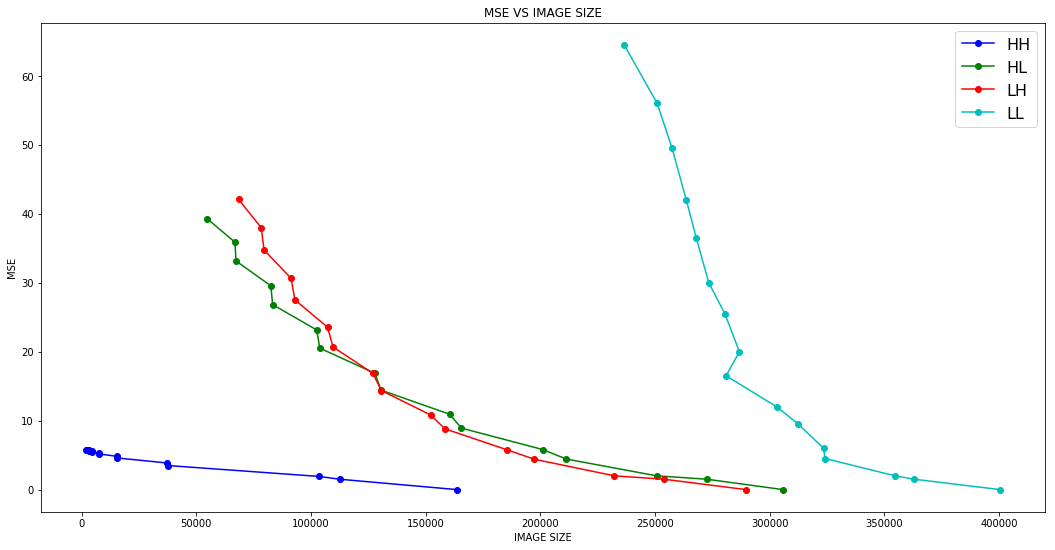

#######################################################################################
[(2.9402765745885948e-05, -50797.5, 0), (4.490837652844231e-05, -9139.0, 0), (2.3997442780370265e-05, -65793.25, 0), (0.000616778214041696, -615.375, 0), (3.333904002098505e-05, -21672.5, 0), (0.0030350616558500274, -76.75, 0), (4.569240805077784e-05, -7740.5, 0), (0.009076155577514247, -14.375, 0), (5.841727759477959e-05, -3042.75, 0), (0.01697555916305922, -4.375, 0), (6.771128405442731e-05, -1397.375, 0), (0.016923630839646365, -2.5, 0), (7.538348822928631e-05, -686.25, 0), (0.03841934974747545, -0.625, 0), (8.369791319282214e-05, -340.75, 0)]
[(4.5317900886281684e-05, -33105.625, 1), (2.2498813777666855e-05, -21947.125, 1), (6.185092745853299e-05, -39355.625, 1), (0.00013448824556065698, -10236.75, 1), (8.749358545564606e-05, -35495.125, 1), (0.00039613909044944567, -5081.875, 1), (0.00011680139255344782, -29954.375, 1), (0.0009256142058908418, -2633.625, 1), (0.00015174861099558035, -24043.625,

In [20]:
R = 6.4 # Bit budget
calculate_rate(midthread, R=R)

## MIDRISE RATE

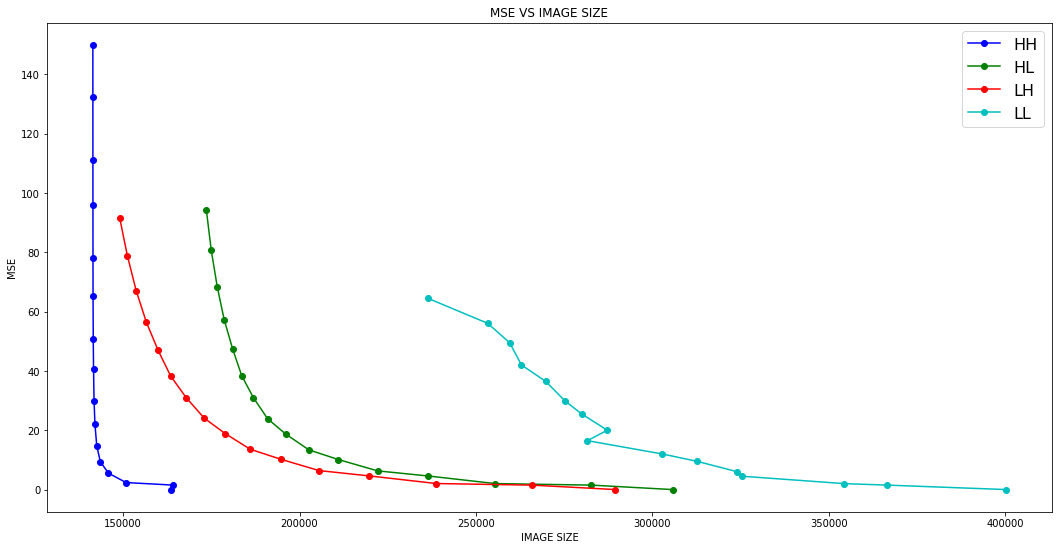

#######################################################################################
[(-0.001994918731366805, 755.125, 0), (6.394162353841101e-05, -13375.875, 0), (0.0006346840505815636, -4991.875, 0), (0.0016678138420807358, -2300.25, 0), (0.005303405855381145, -1024.375, 0), (0.01429043160789953, -507.75, 0), (0.031023097426930192, -252.5, 0), (0.07526418145703766, -143.125, 0), (0.11817882341853789, -86.875, 0), (0.25443368143237927, -56.25, 0), (0.7703126942961815, -16.5, 0), (1.2424064009661833, -14.375, 0), (1.5955159635001321, -9.5, 0), (3.723448393582566, -5.75, 0), (2.235581259018762, -7.875, 0)]
[(6.521135398255668e-05, -22997.875, 1), (1.897656563768019e-05, -27244.25, 1), (0.00013479998951344168, -18950.125, 1), (0.0001201190518681131, -14380.125, 1), (0.0003431146356671207, -11117.75, 1), (0.00039174858409167713, -8384.0, 1), (0.000810659918561039, -6565.5, 1), (0.0010058876463838525, -5118.125, 1), (0.0017671572634701588, -4024.0, 1), (0.002227356663114121, -3290.25, 1

In [21]:
R = 6.4 # Bit budget
size = list(map(lambda x: x[0], midrise['LL'])) 
R = np.min(size)
calculate_rate(midrise, R=R)

## DEADZONE RATE

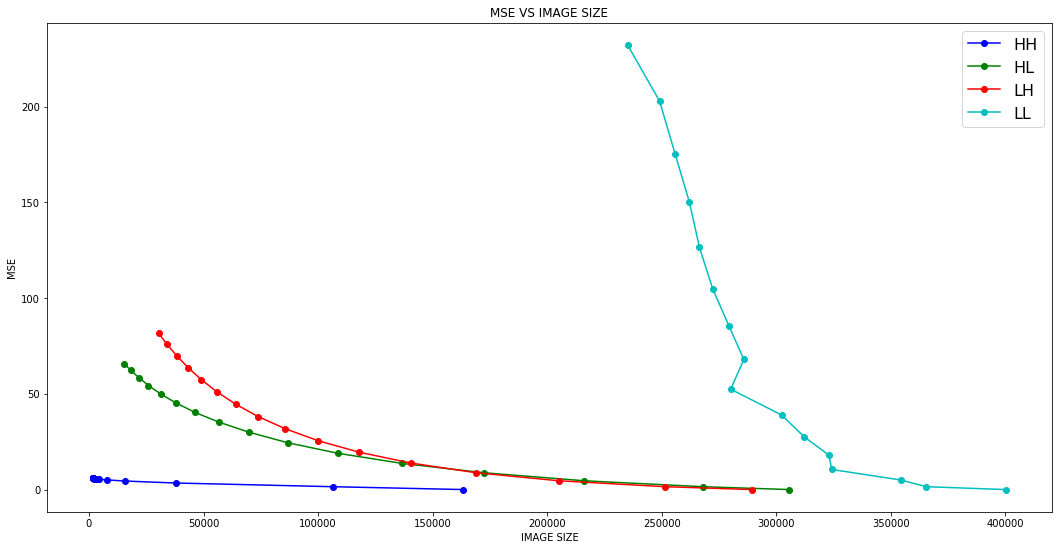

#######################################################################################
[(2.62156410233183e-05, -56973.125, 0), (2.808338712332306e-05, -68710.625, 0), (4.686960342203381e-05, -22239.75, 0), (7.483648672046532e-05, -7870.25, 0), (0.0001063573374430138, -3082.0, 0), (0.00013587740449124653, -1411.5, 0), (0.00016834067206359534, -692.5, 0), (0.00018931557166968898, -343.0, 0), (0.00021960583393388676, -215.5, 0), (0.00022829518388225276, -112.25, 0), (0.0003109779527164083, -53.5, 0), (0.0003170715220856264, -30.5, 0), (0.00038279161096254786, -21.25, 0), (0.0005735119838737303, -7.125, 0), (0.0005521000726967626, -8.25, 0)]
[(3.956310453680921e-05, -37921.125, 1), (5.981376443248103e-05, -51554.5, 1), (9.566437449180971e-05, -43903.625, 1), (0.00013663935907005782, -35854.0, 1), (0.0001896052039158349, -27913.375, 1), (0.0002516265716457191, -21788.125, 1), (0.0003240953628157322, -16869.25, 1), (0.00040279611473535693, -13278.625, 1), (0.0004872611535753769, -10473.75, 

In [22]:
R = 6.4 # Bit budget
size = list(map(lambda x: x[0], deadzone['LL'])) 
R = np.max(size)
calculate_rate(deadzone, R=R)